# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [57]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
userlog = spark.read.json("mini_sparkify_event_data.json")
userlog.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
userlog.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [5]:
userlog.show(n=2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [6]:
userlog.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
userlog.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
print(userlog.describe("artist").show())
print(userlog.describe("sessionID").show())

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

None
+-------+-----------------+
|summary|        sessionID|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+

None


In [28]:
userlog.count()

286500

In [9]:
## check all the categories of page
userlog.select("page").dropDuplicates().sort("page").show(n=30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
## check one certain user
userlog.select(["userId", "firstname", "page", "song"]).where(userlog.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album Version)'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Dog Days Are Over (Radio Edit)'),
 Row(userId='30', firstname='Coli

In [25]:
## calculate statistics by hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [26]:
userlog = userlog.withColumn("hour", get_hour(userlog.ts))

In [30]:
## 0 means 0 am and 22 means 10 pm
userlog.head(n=3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hour='0'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, leve

In [31]:
## show the songs played in each hour
songs_in_hour = userlog.filter(userlog.page == "NextSong").groupby(userlog.hour).count().orderBy(userlog.hour.cast("float"))

In [33]:
songs_in_hour.show(n=25)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



In [34]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

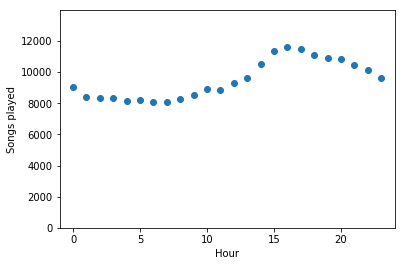

In [35]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");
plt.show()

## Check the Missing Values

In [36]:
userlog.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



In [37]:
userlog.count()

286500

In [38]:
userlog_valid = userlog.dropna(how = "any", subset = ["userId", "sessionId"])

In [39]:
userlog_valid.count()

286500

In [41]:
userlog.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



We notice that the userID has the empty string which might be the users who have not signed up or who are signed out and are about to log in.

In [42]:
userlog_valid = userlog_valid.filter(userlog_valid["userId"] != "")

In [43]:
userlog_valid.count()

278154

## Find the users who downgrade their accounts

In [44]:
## first check all the categories of page
userlog.select("page").dropDuplicates().sort("page").show(n=30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [46]:
userlog_valid.filter("page = 'Submit Downgrade'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  11|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|  21|


In [47]:
## Check the first user's related activites "131"
userlog.select(["userId", "firstname", "page", "level", "song"]).where(userlog.userId == "131").collect()

[Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Fade To Black'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Nothingman (Live)'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Fuck Kitty'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Half The Truth'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='(You Make Me Feel Like A) Natural Woman'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Feel The Beat'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Luno'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Angie Baby'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Robot Soul (Radio Edit)'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Without Me'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free',

In [48]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [49]:
userlog_valid = userlog_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [51]:
userlog_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', downgraded=0)

In [52]:
from pyspark.sql import Window

In [53]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [54]:
userlog_valid = userlog_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [56]:
userlog_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(userlog.userId == "131").sort("ts").collect()

[Row(userId='131', firstname='Kael', ts=1538384355000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538384770000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385046000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385180000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385402000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385558000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386074000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386309000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386520000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386726000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=

In [58]:
## Number of female and male users
userlog_valid.filter(userlog_valid.gender == 'F').select('userId', 'gender').dropDuplicates().count()

104

In [59]:
userlog_valid.filter(userlog_valid.gender == 'M').select('userId', 'gender').dropDuplicates().count()

121

In [61]:
## How many songs were played from the Top 10 most played artist?
userlog_valid.filter(userlog_valid.page == 'NextSong').select('Artist').groupBy('Artist').agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(10)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
+--------------------+-----------+
only showing top 10 rows



In [62]:
## How many songs do users listen to on average between visiting our home page? 
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = userlog_valid.filter((userlog_valid.page == 'NextSong') | (userlog_valid.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
print(df.describe("artist").show())
print(df.describe("sessionID").show())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.